# Tutorial for NIRCam Coronagraphy Reduction with spaceKLIP

---

In this notebook, you will learn how to reduce NIRCam coronagraphy data from the JWST ERS program on Direct Observations of Exoplanetary Systems ([Program 1386](https://www.stsci.edu/jwst/science-execution/program-information?id=1386)), with a focus on the exoplanet HIP 65426 b. The tutorial guides you step-by-step through the data reduction process using the spaceKLIP pipeline, offering a clear and concise workflow tailored for effective high-contrast imaging analysis. By the end of this notebook, you will have gained hands-on experience with the tools and techniques necessary for reducing NIRCam coronagraphic data, preparing you to apply these methods to other similar datasets.

<div class="alert alert-warning">
    
**Related Tutorials and Further Information**: This notebook is intentionally very similar to the ["Tutorial for MIRI Coronagraphy Reduction with spaceKLIP"](https://spaceklip.readthedocs.io/en/latest/tutorials/tutorial_MIRI_reductions.html) notebook.  Subsequent analyses will be done in the ["Tutorial for NIRCam Post-Pipeline Contrast Analyses Using spaceKLIP"](https://spaceklip.readthedocs.io/en/latest/tutorials/tutorial_NIRCam_contrast_analyses.html) notebook. For complete interactive plotting capabilities, download the notebook and execute it locally.
</div>

<div class="alert alert-info">
    
**NIRCam-specific Information**: Steps and information specific to NIRCam are called out in blue.</div>


<h1 style="font-size: 24px;">Table of Contents</h1>

* [1. Introduction](#Introduction)
* [2. Setup and Imports](#Setup-and-Imports)
* [3. Download the Data](#Precursor:-Download-the-Data)
* [4. Stage 1 Reductions](#Stage-1-Reductions)
    * [4.1 Index Files into Database for Stage 1](#Index-Files-into-Database-for-Stage-1)
    * [4.2 Run Stage 1 Pipeline](#Run-Stage-1-Pipeline)
    * [4.3 Display Stage 1 Reductions](#Display-Stage-1-Reductions)
* [5. Stage 2 Reductions](#Stage-2-Reductions)
    * [5.1 Re-read Stage 1 Outputs into Database](#Optional:-Re-read-Stage-1-Outputs-into-Database)
    * [5.2 Run Stage 2 Pipeline](#Run-Stage-2-Pipeline)
    * [5.3 Display Stage 2 Reductions](#Display-Stage-2-Reductions)
* [6. Stage 3 reductions: Preparations for PSF subtraction](#Stage-3-Reductions:-Preparations-for-PSF-Subtraction
)
    * [6.1 Re-read Stage 2 Outputs into Database](#Optional:-Re-read-Stage-2-Outputs-into-Database)
    * [6.2 Using spaceKLIP ImageTools](#Using-spaceKLIP-ImageTools)
    * [6.3 Median-subtract Each Frame](#Median-subtract-Each-Frame)
    * [6.4 Find and Repair Bad Pixels](#Find-and-Repair-Bad-Pixels)
    * [6.5 Finish Pixel Cleanup](#Finish-Pixel-Cleanup)
    * [6.6 Improve PSF Centering and Alignment](#Improve-PSF-Centering-and-Alignment)
        * [6.6.1 Update NIRCam PSF Center Metadata](#Update-NIRCam-PSF-Center-Metadata)
        * [6.6.2 Calculate Recentering Shifts](#Calculate-Recentering-Shifts)
        * [6.6.3 Calculate Alignment Shifts](#Calculate-Alignment-Shifts)
        * [6.6.4 Shift Frames](#Shift-Frames)
    * [6.7 Pad Empty Space Around Frames](#Pad-Empty-Space-Around-Frames)
    * [6.8 Display the Cleaned Datasets](#Display-the-Cleaned-Datasets)
* [7. Stage 3 Reductions: KLIP](#Stage-3-Reductions:-KLIP)
    * [7.1 PSF Subtraction: Option Using pyKLIP](#PSF-Subtraction:-Option-Using-pyKLIP)
    * [7.2 Re-read Stage 3 Outputs into Database](#Optional:-Re-read-Stage-3-Outputs-into-Database)

---

## Introduction

Directly imaging a planet or circumstellar disk around another star is a challenging task that requires specialized techniques and systems to suppress the star's bright light while preserving the faint light from the planet or disk, which otherwise would be obscured by the star's glare. This is achieved using starlight suppression optical systems, such as a starshade occulter or coronagraph, active wavefront control, advanced image processing techniques like differential imaging, and post-processing algorithms that effectively remove residual starlight (also referred to as speckles) using point spread function (PSF) subtraction methods. These advanced astronomical technologies and techniques enable High-Contrast Imaging (HCI), making it possible to study and characterize planetary systems in unprecedented detail.

A coronagraph instrument is a fundamental technology used for HCI as it is designed to block the light of an on-axis source, such as a star's light, using an internal or external occulter while letting the light of off-axis sources, like planets, to continue to pass through the optical system to the detector. The most common type of coronagraph is a Lyot-coronagraph which the Near Infrared Camera (NIRCam) on the James Webb Space Telescope (JWST) exemplifies, featuring five [Lyot-type coronagraphs](https://jwst-docs.stsci.edu/methods-and-roadmaps/jwst-high-contrast-imaging/jwst-high-contrast-imaging-supporting-technical-information/hci-optics#HCIOptics-LyCLyot-typecoronagraph:~:text=in%20the%20documentation.-,Lyot%2Dtype%20coronagraph,-See%20also%3A%C2%A0) that facilitate HCI at wavelengths of 2–5 µm with sub-arcsecond [inner working angles (IWA)](https://jwst-docs.stsci.edu/methods-and-roadmaps/jwst-high-contrast-imaging/jwst-high-contrast-imaging-supporting-technical-information/hci-inner-working-angle#gsc.tab=0:~:text=Inner%20Working%20Angle-,HCI%20Inner%20Working%20Angle,-The%20JWST%20inner) that allow for imaging of objects very close to their host. However, coronagraphs have certain limitations.

While coronagraphs block most of the star's light, there is some star leakage (or diffracted starlight) that propagates to the detector and results in a residual starlight "speckle" pattern or static wavefront errors that require additional post-processing and imaging techniques to remove. Also, the coronagraph design places constraints on the field of view (i.e., IWA), bandpass limitations, etc.

To address the limitations of coronagraphy, differential imaging techniques are used to separate starlight from the faint signals of celestial companions by exploiting differences in target, wavelength, or angular position. We use the following later in the notebook:

* **Angular Differential Imaging (ADI)**: This technique relies on the rotation of the telescope to capture a series of images at different field orientations. By aligning and combining these images, ADI can effectively differentiate the relatively static starlight from the rotating signal of the faint companion, enhancing contrast and detectability.
* **Reference Differential Imaging (RDI)**: This technique uses reference images of similar stars taken under similar observing conditions to subtract starlight from the target star's images. 
* **Spectral Differential Imaging (SDI)**: This technique takes advantage of the wavelength-dependent differences in the light from a star and its companion. Comparing images taken at different wavelengths helps suppress starlight while preserving the signal from the companion.

Post-processing algorithms such as Karhunen-Loève Image Processing (KLIP) are used to perform PSF Subtraction and can enhance differential imaging techniques like ADI, RDI, and SDI. KLIP uses Principal Component Analysis (PCA) to create a model of the residual starlight PSF tailored to the observed data. Subtracting this model from the images helps remove the leftover residual light while preserving the light from faint sources. The [spaceKLIP data reduction pipeline](https://spaceklip.readthedocs.io/en/latest/) simplifies and streamlines the reduction and application of KLIP on JWST high-contrast imaging data.

**ADDITIONAL RESOURCES**

* [HCI Overview](https://iopscience.iop.org/article/10.1088/1538-3873/aceb31#:~:text=HCI%20is%20a%20catchall%20term,the%20vicinity%20of%20bright%20stars.): A comprehensive introduction to High-Contrast Imaging.
* [PCA Example](https://towardsdatascience.com/eigenfaces-recovering-humans-from-ghosts-17606c328184): A clear example to visualize Principal Component Analysis.


---


## Setup and Imports

In [1]:
import os, time
import numpy as np
import subprocess

import spaceKLIP

import matplotlib
matplotlib.rcParams.update({'font.size': 14})
%matplotlib inline

from astropy.io import fits

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-068 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-071
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf
[spaceKLIP.utils:WARNING] Using SVO Filter Profile Service timed out. Using WebbPSF instead.


In [2]:
#ADDED TO CHANGE THE PATH
os.environ["CRDS_PATH"] = "/home/cysil/JWST/projects/Coronography/NIRCam/crds_cache"
print(os.environ["CRDS_PATH"])

/home/cysil/JWST/projects/Coronography/NIRCam/crds_cache


Note that currently the import of `webbpsf_ext` has a side effect of configuring extra verbose logging. We're not interested in that logging text, so let's quiet it. 



In [3]:
import webbpsf_ext
webbpsf_ext.setup_logging('WARN', verbose=False)

---

## Precursor: Download the Data

If you already have a copy of this data, you can adjust the paths below accordingly. In this notebook, we assume you don't have the data yet, so let's download it here.

We will use the `jwst_mast_query` [package](https://github.com/spacetelescope/jwst_mast_query) for this. Consult the package's documentation for more details.

We'll download all the uncalibrated raw data (`uncal.fits`), as we will use spaceKLIP to invoke the [JWST pipeline](https://github.com/spacetelescope/jwst) with customized options and extra steps optimized for coronagraphy.

In [4]:
#Name the root directory where we will keep the data for this tutorial.
data_root = 'data_nircam_hd65426'

In [5]:
# Make subdirectories to put the data in.

#os.makedirs(data_root, exist_ok=True)
#os.makedirs(os.path.join(data_root, 'uncal'), exist_ok=True)

# Invoke the download.
#download_cmd = (
#    "yes | jwst_download.py --propID 1386 -i nircam -l 700 --obsnums 1 2 3 "
#    "--outsubdir data_nircam_hd65426/uncal --skip_propID2outsubdir "
#    "-f uncal --date_select 59789.0+"
#)

#process=subprocess.Popen(download_cmd, shell=True,
#                         stdout=subprocess.PIPE,
#                         stderr=subprocess.PIPE)
#stdout, stderr = process.communicate()

# Uncomment to print the download log and any errors.
#print(stdout.decode())
#print(stderr.decode())

---

## Stage 1 Reductions

### Index Files into Database for Stage 1
SpaceKLIP relies on a `Database` class to track observations, data files, and the relationships between them. 

We begin by creating a database and reading files into it. 

For this tutorial, let's only reduce one filter's worth of data. 

In [6]:
# program = 1386  # Define the program.
# filt = 'F444W'  # Set to None to disable filter selection and load all filters.

In [7]:
# # Initialize spaceKLIP database.

# database = spaceKLIP.database.create_database(
#                                    input_dir=os.path.join(data_root, 'uncal'),
#                                    output_dir=data_root,
#                                    filt=filt,
#                                    pid=program)

The above is a bit verbose and can be difficult for a human to parse; let's ask the database to summarize what it contains: 

In [8]:
#database.summarize()

Above, you should notice two types of files contained in the database:

* **Science** (`SCI`): These files hold the primary coronagraphic observational data of the target—in this case, the exoplanet host star HIP 65426. This program also conducted coronagraphic observations at two separate roll angles, which refer to specific pointing/orientation of the telescope. Hence, there are two `SCI` files.
* **Reference** `REF`: These files contain the reference PSF observations of other stars—in this case, of the nearby star HIP 68245. There are nine `REF` files, one for each dithered exposure.

---

### Run Stage 1 Pipeline

The `Coron1Pipeline` (`calwebb_coron1`[↘️](https://spaceklip.readthedocs.io/en/latest/stage1.html)) in spaceKLIP is a custom subclass of the JWST Stage 1 pipeline, `Detector1Pipeline` (`calwebb_detector1`[↘️](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html#calwebb-detector1)). It is specifically designed to optimize the processing of high-contrast imaging data typical of coronagraphic observations. This pipeline applies group-by-group detector-level corrections, followed by ramp fitting, to the raw, uncalibrated data (`uncal.fits`[↘️](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html#:~:text=g.%20%E2%80%9Cjw80600012001_02101_00003_mirimage_ramp.fits%E2%80%9D.-,Inputs,-%EF%83%81)). The output is calibrated count rate products (`rateints.fits`[↘️](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html#:~:text=be%20ImageModel.-,3D%20countrate%20product,%EF%83%81,-Data%20model)).

The `Coron1Pipeline` performs the following steps for NIRCam. Custom spaceKLIP steps and parameters are marked with stars (⭐). Click on the steps with the attached (ReadtheDocs 📄) links to learn more about specific JWST pipeline steps.

> * `group_scale` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/group_scale/description.html))</span>
> * `dq_init`  <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/dq_init/description.html))</span>
> * `saturation` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/saturation/description.html))</span>    
>    *  `flag_rcsat`: Flag high dark current RC pixels as saturated? (Default: False).    
>    *  `grow_diagonal`: Flag diagonal neighboring pixels (or only bottom/top/left/right)? (Default: True).
>    * `n_pix_grow_sat` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/saturation/arguments.html))</span>  
> * `ipc` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/ipc/description.html))</span>
> * `superbias` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/superbias/description.html))</span>
> * `refpix` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/refpix/index.html))</span>
>    * `odd_even_columns` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/refpix/arguments.html#:~:text=%2D%2D-,odd_even_columns,-If%20the%20odd_even_columns))</span>
>    * ⭐ `nlower`, `nupper`, `nleft`, `nright`: Number of pixels around edges to use as pseudo-refpix in NIRCam subarrays (Default: 4).   
>    * ⭐ `nrow_off`, `ncol_off`: Offset the reference pixel region from the top/bottom and left/right edges of the frame (Default: 0).
> * `linearity` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/linearity/description.html))</span>     
> * `dark_current` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/dark_current/description.html))</span>
> * `persistence` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/persistence/description.html))</span>
> * `jump` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/jump/description.html))</span>
>    * `rejection_threshold` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/jump/arguments.html#:~:text=%2D%2D-,rejection_threshold,-%3A%20A%20floating%2Dpoint))</span> , `three_group_rejection_threshold` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/jump/arguments.html#:~:text=three_group_rejection_threshold))</span>,
>    * `four_group_rejection_threshold` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/jump/arguments.html#:~:text=four_group_rejection_threshold))</span> , `maximum_cores` <span style="font-size: 8px;">([ReadtheDocs📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/jump/arguments.html#:~:text=%2D%2D-,maximum_cores,-%3A%20The%20number%20of))</span>
> * ⭐ `subtract_1overf`: Removes 1/f noise from the data.
>    * ⭐ `model_type`: Type of model to fit for 1/f noise removal ('median', 'mean', Defualt: 'savgol')
>    * ⭐ `sat_frac`: Maximum saturation fraction for fitting slopes (Default: 0.5)
>    * ⭐ `combine_ints`: Combine all integrations before ramp fitting? (Default: True)
>    * ⭐ `vertical_corr`: Apply a vertical correction to remove vertical striping (Default: True)
>    * ⭐ `nproc` : Number of processes to use for parallel processing (Default: 4)
> * `ramp_fit` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/ramp_fitting/description.html))</span>
>    * ⭐ `save_calibrated_ramp`: Save the calibrated ramp? The default is False.
> * `gain_scale` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/gain_scale/description.html))</span>


The following cell will run the `Coron1Pipeline` for all input data in the spaceKLIP database, saving the output to a subdirectory named `stage1`.

In [9]:
program = 1386  # Define the program.
filt = 'F444W'  # Set to None to disable filter selection and load all filters.

In [10]:
#spaceKLIP.coron1pipeline.run_obs(database=database,
#                       steps={'group_scale': {'skip': False},
#                              'dq_init': {'skip': False},
#                              'saturation': {'n_pix_grow_sat': 1,
#                                             'grow_diagonal': False},
#                              'ipc': {'skip': True},
#                              'superbias':{'skip': False},
#                              'refpix': {'odd_even_columns': True,
#                                        'odd_even_rows': True,
#                                         'nlower': 4,
#                                         'nupper': 4,
#                                         'nleft': 4,
#                                         'nright': 4,
#                                         'nrow_off': 0,
#                                         'ncol_off': 0},
#                              'linearity': {'skip': False},
#                              'dark_current': {'skip': True},
#                              'persistence': {'skip': True},
#                              'jump': {'rejection_threshold': 4.,
#                                       'three_group_rejection_threshold': 4.,
#                                       'four_group_rejection_threshold': 4.,
#                                       'maximum_cores': 'all'},
#                              'subtract_1overf': {'model_type': 'savgol',
#                                                  'sat_frac': 0.5,
#                                                  'combine_ints': True,
#                                                  'vertical_corr': True,
#                                                  'nproc': 4},
#                              'ramp_fit': {'save_calibrated_ramp': False,
#                                           'maximum_cores': 'all'},
#                              'gain_scale': {'skip': False}},
#                       subdir='stage1')

We can now examine the updated database, which shows that all available files for each filter have been processed to Stage 1.

**Note**: The Stage 0 files are automatically removed from the database since there is no further processing required for them. However, the files remain on disk.


In [11]:
# database.summarize()

---

### Display Stage 1 Reductions

Let's examine the science and reference PSF data in the F444W filter we processed through the `Coron1Pipeline`. You can use the built-in plotting function `spaceKLIP.plotting.display_coron_dataset` to display the images by passing the database object to the function. Each image includes annotations, with pixels marked as `DO_NOT_USE` in the data quality (DQ) extension highlighted in orange. Additionally, the plotting function allows you to restrict the display to filter specific data and save the images. The `restrict_to` parameter can be a simple string that filters by matching keys in the database or a dictionary that applies filters based on specific columns in the database table. The images will be saved as a PDF file to the current working directory by default or to a specified path if provided by the user passed to the `save_filename` keyword argument. There are also additional parameters, such as `vmin`, `vmax`, and `stretch`, that allow you to adjust the visualization settings for image normalization.

To browse through the files in the database interactively, set `interactive=True`. Doing this will enable a slider to flip through the images. To generate and save static plots in a PDF, set `interactive=False`.


In [12]:
# spaceKLIP.plotting.display_coron_dataset(
#     database,
#     restrict_to={
#         'FILTER': filt,  # Sort by filter.
#         'TYPE': ['SCI']  # Sort by file type SCI/REF.
#     },
#     interactive=True,  # Static or interactive plots?
#     zoom_center=3,  # Optional zoom factor; set to None to disable.
#     vmin=0, vmax=1e3,  # Define the min/max values for consistent image scaling.
#     save_filename=f'{data_root}/plots_{filt}_stage1.pdf'  # Save plots to PDF.
# )

---

## Stage 2 Reductions

### Optional: Re-read Stage 1 Outputs into Database 

This shows how you can start re-reductions at this stage in the processing, once the previous steps have been completed. You might want to re-read the data if, for example, you have been provided with files that have already been processed through Stage 1 but require further reductions.

In [13]:
# Start a timer to keep track of runtime
time0 = time.perf_counter()

In [14]:
database = spaceKLIP.database.create_database(
                                    input_dir=os.path.join(data_root, 'stage1'),
                                    file_type='rateints.fits',
                                    output_dir=data_root,
                                    filt=filt,
                                    pid=program)

[spaceKLIP.database:INFO] --> Identified 1 concatenation(s)
[spaceKLIP.database:INFO]   --> Concatenation 1: JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
TYPE  EXP_TYPE DATAMODL TELESCOP ... CENTER_MASK      ROLL_REF      BLURFWHM
---- --------- -------- -------- ... ----------- ------------------ --------
 SCI NRC_CORON   STAGE1     JWST ...   [0.0 0.0] 110.30193021095504      nan
 SCI NRC_CORON   STAGE1     JWST ...   [0.0 0.0] 120.38229928196697      nan
 REF NRC_CORON   STAGE1     JWST ...   [0.0 0.0] 110.03164122132496      nan
 REF NRC_CORON   STAGE1     JWST ...   [0.0 0.0] 110.03167106048886      nan
 REF NRC_CORON   STAGE1     JWST ...   [0.0 0.0] 110.03169329703867      nan
 REF NRC_CORON   STAGE1     JWST ...   [0.0 0.0] 110.03168369754667      nan
 REF NRC_CORON   STAGE1     JWST ...   [0.0 0.0] 110.03167513985059      nan
 REF NRC_CORON   STAGE1     JWST ...   [0.0 0.0] 110.03166494498083      nan
 REF NRC_CORON   STAGE1     JWST ...   [0.0 0.0] 110.031644105486

---

### Run Stage 2 Pipeline

The `Coron2Pipeline` (`calwebb_coron2`][↘️](https://spaceklip.readthedocs.io/en/latest/stage2.html)) in spaceKLIP is a customized subclass of the JWST Stage 2 Imaging Pipeline, `Image2Pipeline` (`calwebb_image2`[↘️](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_image2.html)), specifically designed to optimize the processing of high-contrast imaging data typical of coronagraphic observations. This stage requires little customization. This pipeline performs additional corrections and calibrations on the countrate products (`rateints.fits`[↘️](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_image2.html#:~:text=per%2Dintegration%20results)) from stage 1 to produce fully calibrated products (`calints.fits`[↘️](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_image2.html#:~:text=2D%20or%203D%20calibrated,%EF%83%81)). 

The `Coron2Pipeline` includes the following steps for NIRCam. Custom spaceKLIP steps and parameters are bolded. Click on the steps with the attached (ReadtheDocs 📄) links to learn more about specific JWST pipeline steps.

> * `bkg_subtract` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/background_step/index.html#background-step))</span>
> * `assign_wcs` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/assign_wcs/index.html#assign-wcs-step))</span>
> * `flat_field` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/flatfield/index.html#flatfield-step))</span>
> * `photom` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/photom/index.html#photom-step))</span>
> * ⭐ `outlier_detection` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/outlier_detection/outlier_detection_coron.html))</span>

The following cell will run the `Coron2Pipeline` for all input data in the spaceKLIP database, saving the output to a subdirectory named `stage2`.

In [15]:
spaceKLIP.coron2pipeline.run_obs(database=database,
                                steps={'bkg_subtract': {'skip': False},
                                       'assign_wcs': {'skip': False},
                                       'flat_field': {'skip': False},
                                       'photom': {'skip': False},
                                       'outlier_detection': {'skip': False}},
                                subdir='stage2')

[spaceKLIP.coron2pipeline:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw01386002001_0310a_00001_nrcalong_rateints.fits
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw01386003001_0310a_00001_nrcalong_rateints.fits
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw01386001001_0310e_00001_nrcalong_rateints.fits
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw01386001001_0310e_00002_nrcalong_rateints.fits
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw01386001001_0310e_00003_nrcalong_rateints.fits
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw01386001001_0310e_00004_nrcalong_rateints.fits
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw01386001001_0310e_00005_nrcalong_rateints.fits
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw01386001001_0310e_00006_nrcal

Again, we can check that the database now contains stage 2 reduced versions of all the files:

In [16]:
database.summarize()

NIRCAM_F444W_MASK335R
	STAGE2: 11 files;	2 SCI, 9 REF


---

In [17]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.0f} seconds")

Runtime so far: 21 seconds


### Display Stage 2 Reductions

These images look nearly identical to the Stage 1 outputs, but note that the display units have been rescaled from DN/s (countrate) to physical units of MJy/sr (surface brightness). You may also notice that more pixels have been flagged as `DO_NOT_USE` after applying the outlier detection step in Stage 2.


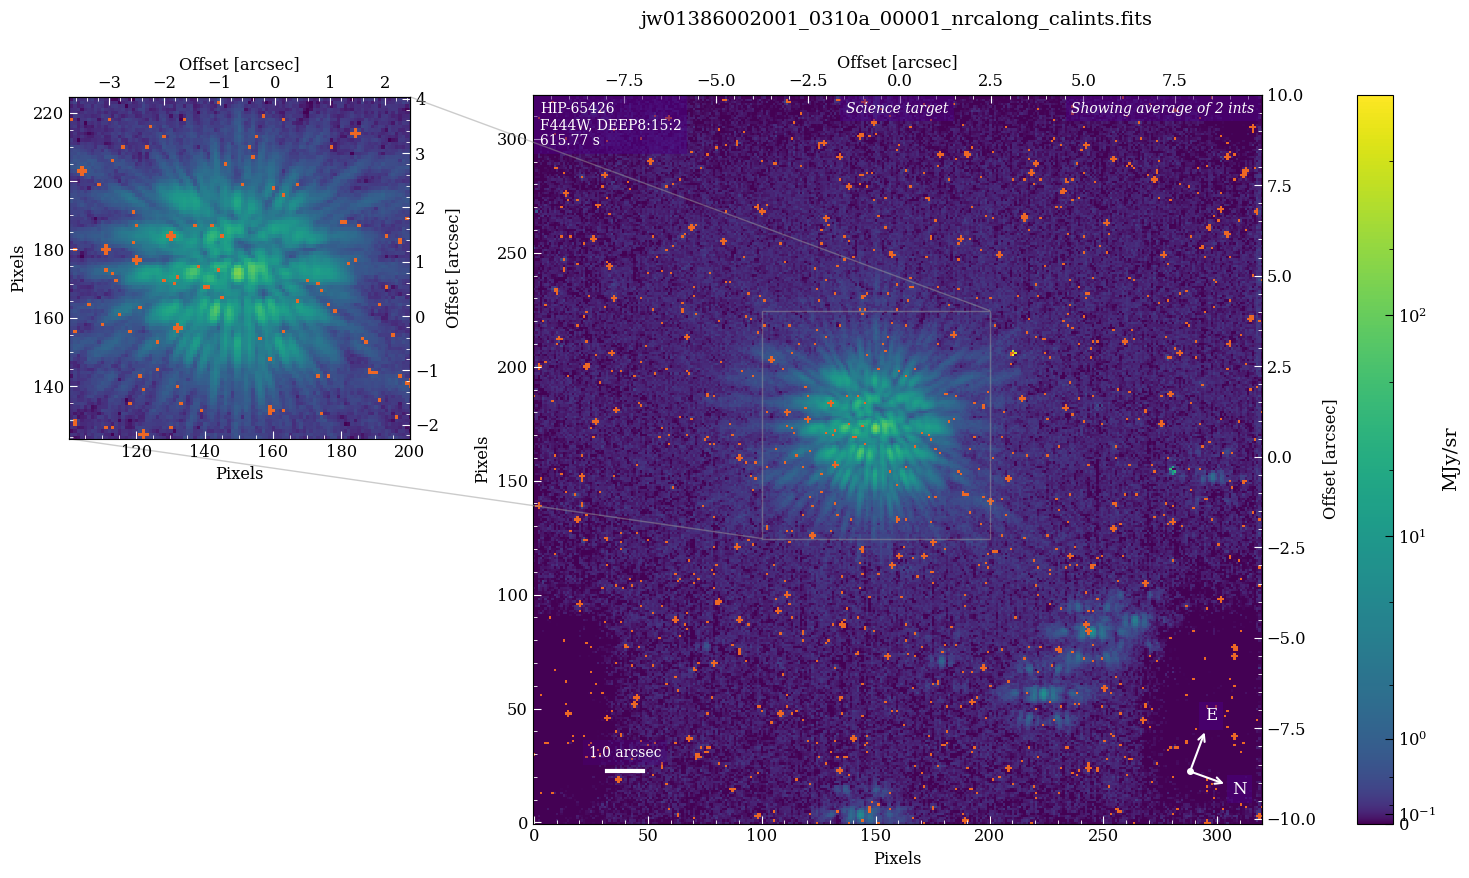

IntSlider(value=0, description='Image  Index:', max=1)

Output()

In [18]:
spaceKLIP.plotting.display_coron_dataset(
    database,
    restrict_to={
        'FILTER': filt,  # Sort by filter.
        'TYPE': ['SCI']  # Sort by file type SCI/REF.
    },
    interactive=True,  # Static or interactive plots?
    zoom_center=3,  # Optional zoom factor; set to None to disable.
    vmin=0, vmax=1e3,  # Define the min/max values for consistent image scaling.
    save_filename=f'{data_root}/plots_{filt}_stage2.pdf'  # Save plots to PDF.
)

---

## Stage 3 Reductions: Preparations for PSF Subtraction

As is often the case in high-contrast imaging, obtaining good PSF subtractions depends sensitively on preparing the data ahead of time.

In the following section, we improve coronagraphic reductions, taking special care with image centering, background subtraction, and bad pixel replacement/interpolation, all before the PSF subtraction steps.

---

### Optional: Re-read Stage 2 Outputs into Database
This shows how you can start re-reductions at this stage in the processing, once the previous steps have been completed.

In [19]:
database = spaceKLIP.database.create_database(
                                    input_dir=os.path.join(data_root, 'stage2'),
                                    file_type='calints.fits',
                                    output_dir=data_root,
                                    filt=filt,
                                    pid=program)

[spaceKLIP.database:INFO] --> Identified 1 concatenation(s)
[spaceKLIP.database:INFO]   --> Concatenation 1: JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
TYPE  EXP_TYPE DATAMODL TELESCOP ... CENTER_MASK      ROLL_REF      BLURFWHM
---- --------- -------- -------- ... ----------- ------------------ --------
 SCI NRC_CORON   STAGE2     JWST ...   [0.0 0.0] 110.30193021095504      nan
 SCI NRC_CORON   STAGE2     JWST ...   [0.0 0.0] 120.38229928196697      nan
 REF NRC_CORON   STAGE2     JWST ...   [0.0 0.0] 110.03164122132496      nan
 REF NRC_CORON   STAGE2     JWST ...   [0.0 0.0] 110.03167106048886      nan
 REF NRC_CORON   STAGE2     JWST ...   [0.0 0.0] 110.03169329703867      nan
 REF NRC_CORON   STAGE2     JWST ...   [0.0 0.0] 110.03168369754667      nan
 REF NRC_CORON   STAGE2     JWST ...   [0.0 0.0] 110.03167513985059      nan
 REF NRC_CORON   STAGE2     JWST ...   [0.0 0.0] 110.03166494498083      nan
 REF NRC_CORON   STAGE2     JWST ...   [0.0 0.0] 110.031644105486

---

### Using spaceKLIP ImageTools

This is where we will do some extra image processing to improve coronagraphic reductions. SpaceKLIP's image manipulation tools class, `ImageTools`, allows you to perform tasks like image alignment, bad pixel cleaning, and more directly on the data in the database.


In [20]:
# Initialize spaceKLIP image manipulation tools class.
imageTools = spaceKLIP.imagetools.ImageTools(database=database)

---

### Median-subtract Each Frame

Median subtraction is a recommended preprocessing step for NIRCam data, as it enhances the accuracy and reliability of PSF subtractions produced by algorithms like KLIP. The `subtract_median` function calculates the median image, which represents the median background level and any static artifacts across frames (integrations) within a data product. By subtracting this median image from each frame, the process reduces uncalibrated bias drifts and better isolates the signal from the source PSF, as demonstrated in the plot below.

Median subtraction gets applied to all files in the database after masking out bright sources using sigma clipping or similar techniques. The `subtract_median` method supports the following median subtraction methods:

> * `robust`: Computes the median after masking bright stars using Median Absolute Deviation (MAD).
> * `sigma_clipped`: Uses `astropy.stats.sigma_clipped_stats` to robustly calculate the median, clipping outliers based on a specified `sigma` value.
> * `border` (default): Computes the median using data only from the outer border of the image, excluding bright central sources.
> * `simple`: Performs a straightforward median calculation without additional masking or clipping.

<div class="alert alert-info">
    
**NIRCam-specific Information**: The `subtract_median` background subtraction step is only recommended for NIRCam, not MIRI.</div>

In [21]:
# Median-subtract each frame to mitigate uncalibrated bias drifts.
imageTools.subtract_median(types=['SCI', 'SCI_TA', 'SCI_BG', 'REF', 'REF_TA', 'REF_BG'],
                           subdir='medsub')

[spaceKLIP.imagetools:INFO] Median subtraction using method=border
[spaceKLIP.imagetools:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.imagetools:INFO]   --> Median subtraction: jw01386002001_0310a_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Median subtraction: mean of frame median = 0.09
[spaceKLIP.imagetools:INFO]   --> Median subtraction: jw01386003001_0310a_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Median subtraction: mean of frame median = 0.09
[spaceKLIP.imagetools:INFO]   --> Median subtraction: jw01386001001_0310e_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Median subtraction: mean of frame median = 0.19
[spaceKLIP.imagetools:INFO]   --> Median subtraction: jw01386001001_0310e_00002_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Median subtraction: mean of frame median = 0.19
[spaceKLIP.imagetools:INFO]   --> Median subtraction: jw01386001001_0310e_00003_nrcalong_calint

In [22]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.0f} seconds")

Runtime so far: 26 seconds


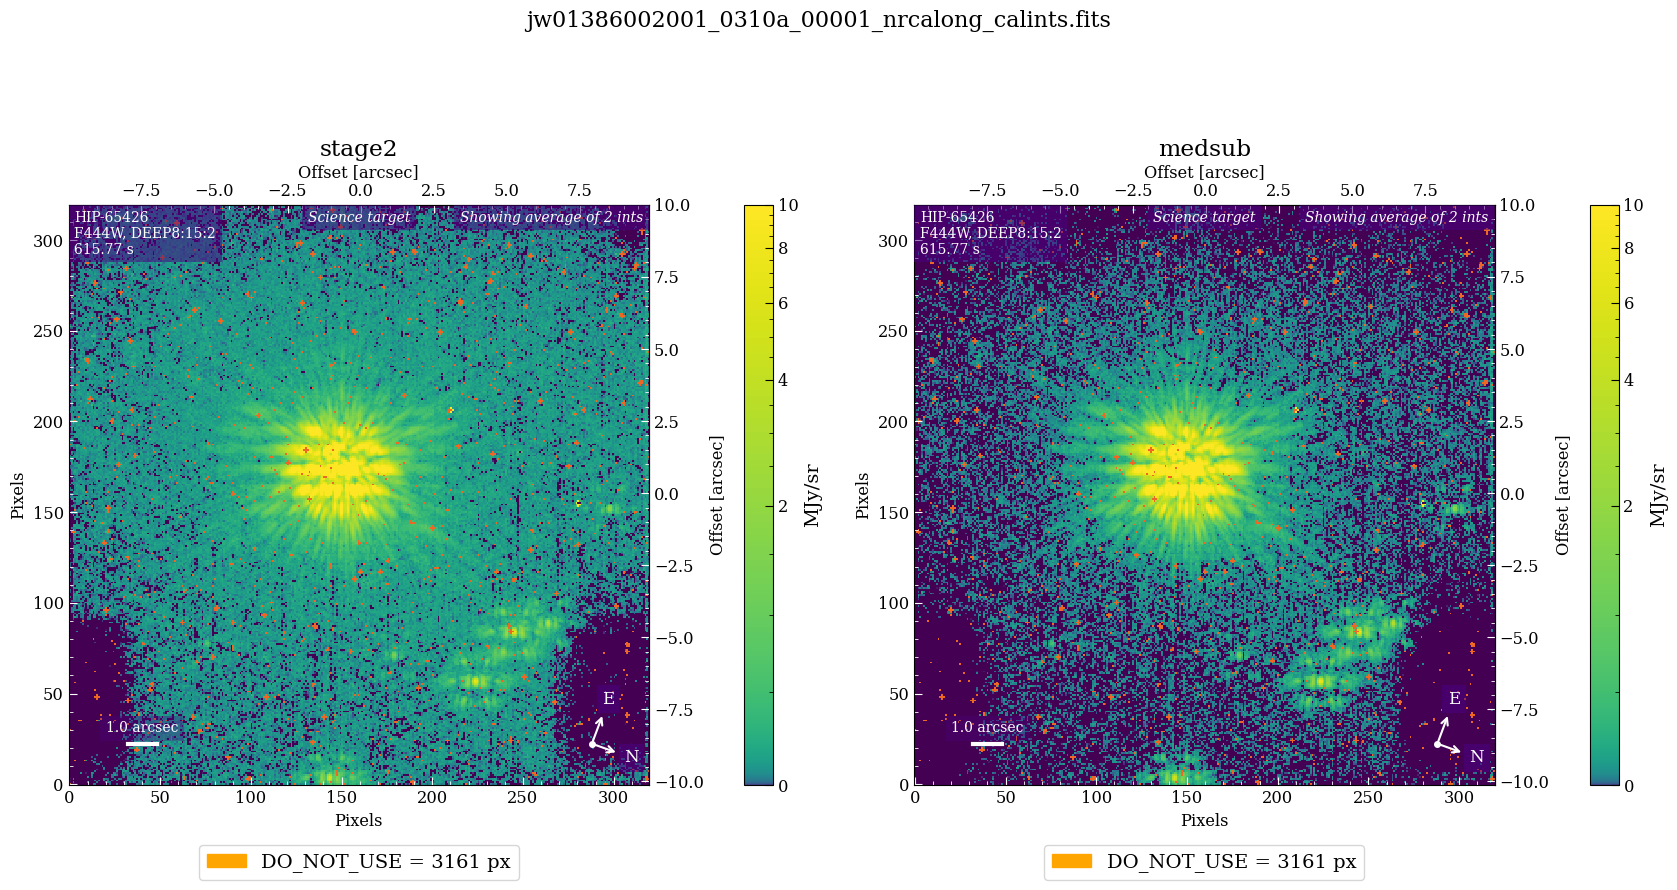

IntSlider(value=0, description='Image Index:', max=1)

Output()

In [23]:
# Compare before and after median subtraction.

spaceKLIP.plotting.display_image_comparisons(
    database,
    ['stage2', 'medsub'],  # Subdirectories to look for files in.
    restrict_to={'FILTER': filt,  # Sort by filter.
                 'TYPE': ['SCI']  # Sort by file type SCI/REF.
    },
    interactive=True,  # Static or interactive plots?
    vmin=0, vmax=10,  # Define the min/max values for consistent image scaling.
    save_filename=f'{data_root}/medsub_{filt}_comparison.pdf')

---

### Find and Repair Bad Pixels

For NIRCam, the JWST pipeline does not sufficiently repair bad pixels (i.e., anomalous outliers) within the coronagraphic subarrays.

Here, we use the custom functions within spaceKLIP to detect and repair these bad pixels in the following stages:
1. Clean bad pixels identified in the DQ array. 
2. Clean bad pixels using a custom mask for lingering DQ arr pixels.
3. Identify and clean bad pixels from temporal variations across integrations.
4. Identify and clean bad pixels from spatial variations. Use an iterative sigma clipping algorithm to identify additional bad pixels in the data.

In [24]:
# Fix bad pixels using custom spaceKLIP routines. Multiple routines can be
# combined in a custom order.

# ---------------------------------------------------------------
# 'dqarr': uses DQ array to identify bad pixels.
# 'interp2d': replace bad pixels with an interpolation of neighbouring pixels.
imageTools.find_bad_pixels(method='dqarr', subdir='bpfound_dq')
imageTools.clean_bad_pixels(method='interp2d',
                            interp2d_kwargs={'size': 4},
                            subdir='bpcleaned_dq')

# ---------------------------------------------------------------
# 'custom': use a custom bad pixel map.
# 'interp2d': replace bad pixels with an interpolation of neighbouring pixels.
custom_mask = {}
f444w_coords = [[209,205], [210, 205], [209, 206], [210, 206],
                [210, 207], [211, 206], [212,206], [188, 73],
                [189, 73], [188, 74], [280, 153], [279, 153],
                [280, 154], [279, 154], [279, 155], [280, 156],
                [24, 216], [25, 216]]
for i in list(database.obs.keys()):
    data_shape = fits.getdata(database.obs[i][0]['FITSFILE'], ext=1).shape[1:]
    custom_mask[i] = np.zeros(data_shape)
    if 'F444W' in i:
        for coord in f444w_coords:
            custom_mask[i][coord[1], coord[0]] = 1

imageTools.find_bad_pixels(method='custom',
                           custom_kwargs=custom_mask,
                           subdir='bpfound_custom')
imageTools.clean_bad_pixels(method='interp2d',
                            interp2d_kwargs={'size': 4},
                            subdir='bpcleaned_custom')

# ---------------------------------------------------------------
# 'timeints': identify bad pixels from temporal variations across integrations.
# 'timemed': replace pixels which are only bad in some frames with 
#            their median value from the good frames.
imageTools.find_bad_pixels(method='timeints',
                           timeints_kwargs={'sigma': 6},
                           subdir='bpfound_time')  
imageTools.clean_bad_pixels(method='timemed', subdir='bpcleaned_time')

# ---------------------------------------------------------------
# 'sigclip': use sigma clipping to identify additional bad pixels.
# 'interp2d': replace bad pixels with an interpolation of neighbouring pixels.
# 'shift_x/y': Define the range of pixel shifts (left/right and up/down)
#              used in sigma clipping to compare a pixel with its 
#              neighbors and identify deviations.
imageTools.find_bad_pixels(method='sigclip',
                           sigclip_kwargs={'sigma': 3,
                                           'neg_sigma': 3,
                                           'shift_x': [-2, -1, 0, 1, 2],
                                           'shift_y': [-2, -1, 0, 1, 2]},
                           subdir='bpfound_sigclip')  
imageTools.clean_bad_pixels(method='interp2d',
                            interp2d_kwargs={'size': 4},
                            subdir='bpcleaned_sigclip')

[spaceKLIP.imagetools:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.imagetools:INFO]   --> Method dqarr: jw01386002001_0310a_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method dqarr: jw01386003001_0310a_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method dqarr: jw01386001001_0310e_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method dqarr: jw01386001001_0310e_00002_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method dqarr: jw01386001001_0310e_00003_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method dqarr: jw01386001001_0310e_00004_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method dqarr: jw01386001001_0310e_00005_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method dqarr: jw01386001001_0310e_00006_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method dqarr: jw01386001001_0310e_00007_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> 


[spaceKLIP.imagetools:INFO]   --> Method timeints: identified 0 additional bad pixel(s) -- 0.00%

[spaceKLIP.imagetools:INFO]   --> Method timeints: identified 0 additional bad pixel(s) -- 0.00%

[spaceKLIP.imagetools:INFO]   --> Method timeints: identified 0 additional bad pixel(s) -- 0.00%

[spaceKLIP.imagetools:INFO]   --> Method timeints: identified 0 additional bad pixel(s) -- 0.00%

[spaceKLIP.imagetools:INFO]   --> Method timeints: identified 0 additional bad pixel(s) -- 0.00%
[spaceKLIP.imagetools:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.imagetools:INFO]   --> Method timemed: jw01386002001_0310a_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method timemed: fixing 0 bad pixel(s) -- 0.00%
[spaceKLIP.imagetools:INFO]   --> Method timemed: jw01386003001_0310a_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method timemed: fixing 0 bad pixel(s) -- 0.00%
[spaceKLIP.imagetools:INFO]   --> Method timemed: 

If you need to define one, the function `custom_bpfinder` below can help visualize the images and identify bad pixels. Note that the interactive plots require `plotly` to be installed.


In [25]:
# Helper function to identify bad pixels not found above.
def custom_bpfinder(file):

    # Check if plotly is installed.
    try:
        import plotly.graph_objects as go
    except ImportError:
        print("Plotly is not installed.")
        return

    # Load in image data.
    data = fits.getdata(file, ext=1)
    data = data if data.ndim == 2 else data[-1]

    # Generate hover text.
    hover_text = [[f"x: {x}, y: {y}, value: {data[y, x]:.2f}"
                   for x in range(data.shape[1])] for y in range(data.shape[0])]
    
    # Plot the image.
    zmin = np.nanpercentile(data, 1)
    zmax = np.nanpercentile(data, 98)
    fig = go.Figure(data=go.Heatmap(z=data, zmin=zmin, zmax=zmax,
                    hoverinfo="text", text=hover_text,
                    colorscale='Viridis', colorbar=dict(title="Pixel Value")))
    fig.update_layout(title=os.path.basename(file), 
                      xaxis_title="X (pixels)", yaxis_title="Y (pixels)",
                      width=800, height=800)
    fig.show()

# Pick a file to look at.
# custom_bpfinder(database.obs['JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R'][0]['FITSFILE'])

Again, let's examine the results, but this time focusing on the cleaned products.



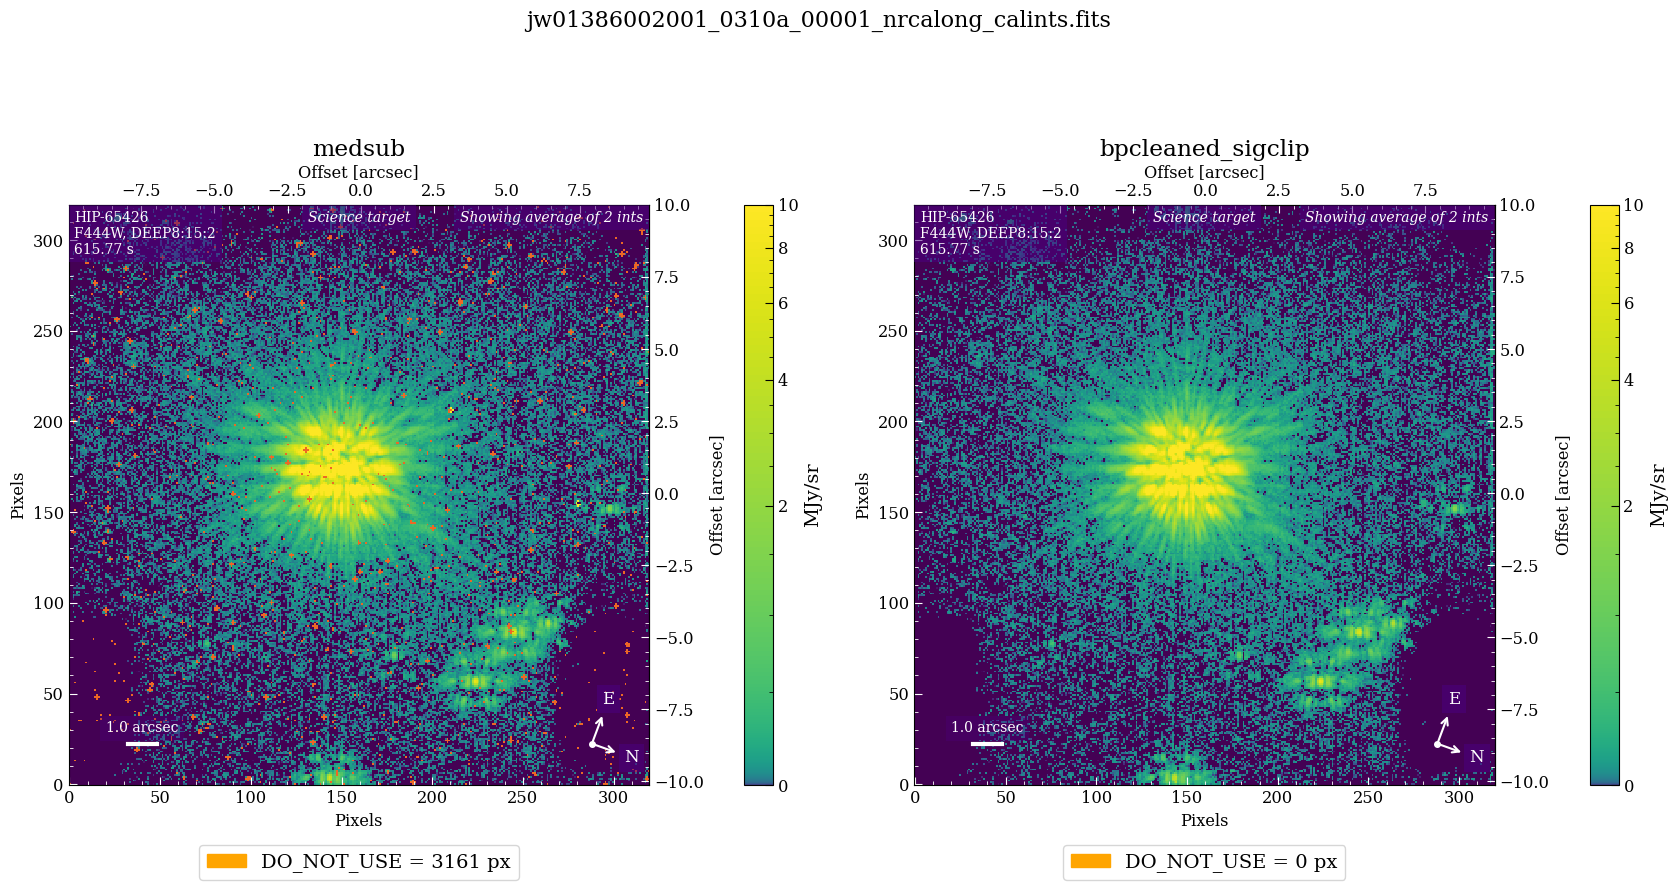

IntSlider(value=0, description='Image Index:', max=1)

Output()

In [26]:
# Compare how well each cleaning method did to replace bad pixels.

spaceKLIP.plotting.display_image_comparisons(
    database,
    ['medsub', 'bpcleaned_sigclip'],  # Subdirectories to look for files in.
    restrict_to={'FILTER': filt,  # Sort by filter.
                 'TYPE': ['SCI']  # Sort by file type SCI/REF.
    },
    interactive=True,  # Static or interactive plots?
    vmin=0, vmax=10, # Define the min/max values for consistent image scaling.
    save_filename=f'{data_root}/clean_bp_{filt}_comparison.pdf')

---

In [27]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.0f} seconds")

Runtime so far: 99 seconds


### Finish Pixel Cleanup

Optionally, any remaining bad pixels can be interpolated to replace NaNs with zeros.

In this case, this step is not strictly necessary since all the bad pixels have already been addressed in the previous steps. However, running this step for example purposes will not alter any pixel values, as they have already been fixed.

In [28]:
# Replace nans.
imageTools.replace_nans(cval=0., # Fill value.
                        types=['SCI', 'SCI_BG', 'REF', 'REF_BG'],
                        subdir='nanreplaced')

[spaceKLIP.imagetools:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.imagetools:INFO]   --> Nan replacement: jw01386002001_0310a_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Nan replacement: replaced 23 nan pixel(s) with value 0.0 -- 0.01%
[spaceKLIP.imagetools:INFO]   --> Nan replacement: jw01386003001_0310a_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Nan replacement: replaced 31 nan pixel(s) with value 0.0 -- 0.02%
[spaceKLIP.imagetools:INFO]   --> Nan replacement: jw01386001001_0310e_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Nan replacement: replaced 0 nan pixel(s) with value 0.0 -- 0.00%
[spaceKLIP.imagetools:INFO]   --> Nan replacement: jw01386001001_0310e_00002_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Nan replacement: replaced 0 nan pixel(s) with value 0.0 -- 0.00%
[spaceKLIP.imagetools:INFO]   --> Nan replacement: jw01386001001_0310e_00003_nrcalong_calints.fits
[spac

---

### Improve PSF Centering and Alignment

In HCI, especially when using techniques like PSF subtraction, precise alignment of images is essential. Misalignment can introduce artifacts to the data, such as residual PSF structure and starlight, that interfere with detecting faint signals.

The alignment process for NIRCam data with spaceKLIP can be broken down into the following steps: `update_nircam_centers`, `calculate_centers`, `calculate_alignment`, and `shift_frames`. 

---

#### Update NIRCam PSF Center Metadata

This is an extra step to update header metadata for locations of the coronagraphs.

This uses a table of better center locations measured by Jarron Leisenring.
Replaces the header values for the CRPIX locations for the mask locations.

Eventually the more precise location information will be in [CRDS](https://jwst-crds.stsci.edu/) and this step will not be necessary. 

In [29]:
database = spaceKLIP.database.create_database(
                                    input_dir=os.path.join(data_root, 'nanreplaced'),
                                    file_type='calints.fits',
                                    output_dir=data_root,
                                    filt=filt,
                                    pid=program)

imageTools = spaceKLIP.imagetools.ImageTools(database=database)
# This changes only the mask center information in the database table.
# No change in the observed data.
imageTools.update_nircam_centers()

[spaceKLIP.database:INFO] --> Identified 1 concatenation(s)
[spaceKLIP.database:INFO]   --> Concatenation 1: JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
TYPE  EXP_TYPE DATAMODL TELESCOP ... CENTER_MASK      ROLL_REF      BLURFWHM
---- --------- -------- -------- ... ----------- ------------------ --------
 SCI NRC_CORON   STAGE2     JWST ...   [0.0 0.0] 110.30193021095504      nan
 SCI NRC_CORON   STAGE2     JWST ...   [0.0 0.0] 120.38229928196697      nan
 REF NRC_CORON   STAGE2     JWST ...   [0.0 0.0] 110.03164122132496      nan
 REF NRC_CORON   STAGE2     JWST ...   [0.0 0.0] 110.03167106048886      nan
 REF NRC_CORON   STAGE2     JWST ...   [0.0 0.0] 110.03169329703867      nan
 REF NRC_CORON   STAGE2     JWST ...   [0.0 0.0] 110.03168369754667      nan
 REF NRC_CORON   STAGE2     JWST ...   [0.0 0.0] 110.03167513985059      nan
 REF NRC_CORON   STAGE2     JWST ...   [0.0 0.0] 110.03166494498083      nan
 REF NRC_CORON   STAGE2     JWST ...   [0.0 0.0] 110.031644105486

---

#### Calculate Recentering Shifts

Recentering is an important pre-processing step, especially for NIRCam data. If we skip directly to the `calculate_alignment` step without recentering, we would assume that the CRPIX values in the header accurately reflect the star's precise location, which is also the KLIP center (the central position used for PSF modeling and subtraction). While this approach has been effective for instruments like MIRI, relying solely on CRPIX values can lead to inaccuracies for NIRCam due to uncertainties in the star's position behind the coronagraph, and therefore in the KLIP center.

To better measure the location of the star with respect to the coronagraph, we provide two options: 
1. Create a simulation of the star behind the coronagraph (using `stpsf`), and cross-correlate this with the observed PSF. The cross-correlation peak is used to infer the offset of the star relative to the mask center. The accuracy of this algorithm is around 7 milliarcsec according to testing. 
2. Use target acquisition (TA) data if available to obtain a more accurate estimate of the star’s location relative to the coronagraph by setting `use_ta=True`. This method can be helpful if one is unable to get a good estimate of the star positon in their field.

The shift needed to center the star is calculated and stored based on the following options:

1. **Default** (`first_sci_only=True`): The shift is calculated from the first SCI frame and applied to all subsequent frames, preparing them for the `calculate_alignment` step.
2. **Per-frame** (`first_sci_only=False`): The shift is calculated and stored individually to each frame. In this case, the `calculate_alignment` step should be skipped, as each frame is already centered. Typically, however, we find that relative alignment (`first_sci_only=True`) is more accurate than shifting each individually.

This step also shifts to account for the coronagraph not being precisely centered in the subarray. After the `shift_frames` step, the star center will be at the center of the pixel. 

[spaceKLIP.imagetools:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.imagetools:INFO]   --> Calculating centers: jw01386002001_0310a_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Recenter frames: generating WebbPSF image for absolute centering (this might take a while)
[spaceKLIP.psf:INFO] Generating on-axis and off-axis PSFs...
[spaceKLIP.psf:INFO]   Done.
[spaceKLIP.imagetools:INFO]   --> Recenter frames: star offset between frame 0 and coronagraph center (dx, dy) = (0.111, -0.129) pix
[spaceKLIP.imagetools:INFO]   --> Recenter frames: star offset between frame 1 and coronagraph center (dx, dy) = (0.107, -0.122) pix
[spaceKLIP.imagetools:INFO]   --> Recenter frames: median star offset from coronagraph center (dx, dy) = (0.109, -0.125) pix
[spaceKLIP.imagetools:INFO]   --> Recenter frames: std for the star offset from coronagraph center (dx, dy) = (0.002, 0.004) pix
[spaceKLIP.imagetools:INFO]  Plot saved in data_nircam_hd654

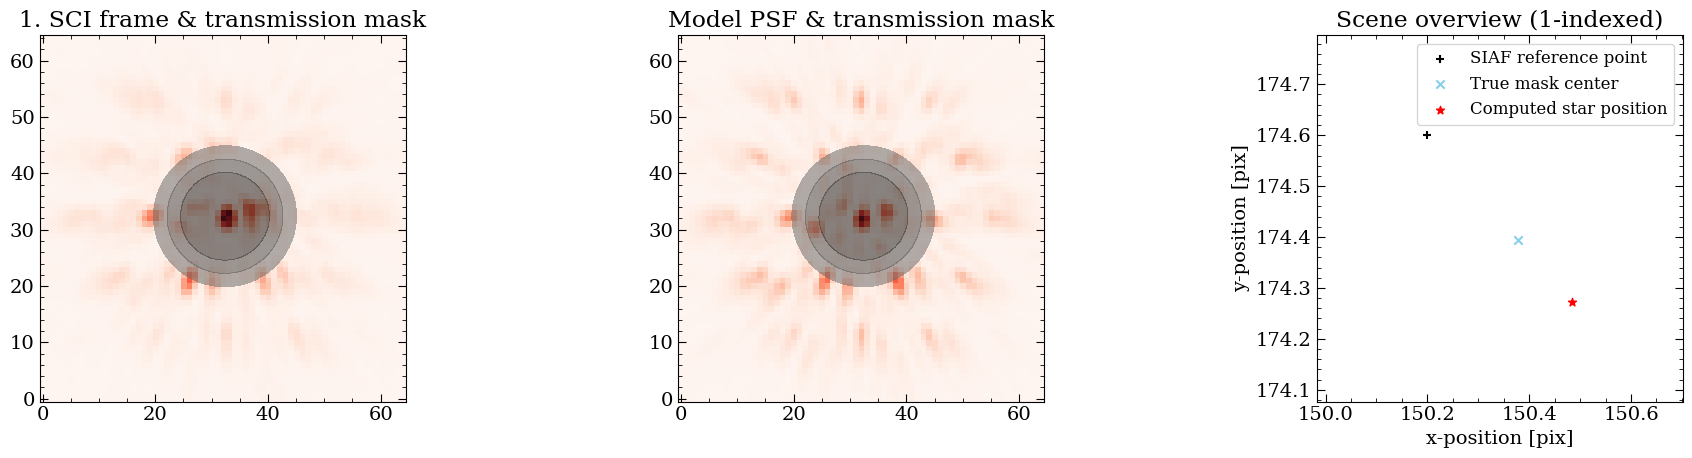

[spaceKLIP.imagetools:INFO]   --> Calculate centers: adjusted XOFFSET/YOFFSET relative to first SCI frame.
[spaceKLIP.imagetools:INFO]   --> Calculate centers: median measured shift = 1063.07 mas
[spaceKLIP.imagetools:INFO]   --> Calculating centers: jw01386003001_0310a_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Calculate centers: adjusted XOFFSET/YOFFSET relative to first SCI frame.
[spaceKLIP.imagetools:INFO]   --> Calculate centers: median measured shift = 1063.07 mas
[spaceKLIP.imagetools:INFO]   --> Calculating centers: jw01386001001_0310e_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Calculate centers: adjusted XOFFSET/YOFFSET relative to first SCI frame.
[spaceKLIP.imagetools:INFO]   --> Calculate centers: median measured shift = 1063.07 mas
[spaceKLIP.imagetools:INFO]   --> Calculating centers: jw01386001001_0310e_00002_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Calculate centers: adjusted XOFFSET/YOFFSET relative to first SCI fra

In [30]:
first_sci_only = True  # Recenter based on first SCI frame.
imageTools.calculate_centers(spectral_type='A2V', subdir='recenter_shifts', 
                             use_ta=False, first_sci_only=first_sci_only)

# The spectral type is used to make a more accurate PSF simulation for the star.

* `use_ta = False`:
    The output plot features three panels: the first displays the cropped science image with the transmission mask, the second shows the cropped modeled PSF and transmission mask, and the third depicts the computed star position behind the coronagraph, determined by cross-correlating the science (true mask center) and the model PSF (SIAF reference point). Additionally, this step saves output PDFs with plots that detail the centering results.
* `use_ta = True`:
    The plots output above illustrate the TA data, including the measured centroid on board (OSS) and where the WCS expects the star to be. From this data we calculate the offset needed to correct the WCS and determine the true location of the star behind the coronagraph. Additionally, this step saves output PDFs with plots that detail the centering results.

In [31]:
!ls data_nircam_hd65426/recenter_shifts/*pdf

data_nircam_hd65426/recenter_shifts/jw01386002001_0310a_00001_nrcalong_calints.pdf


In [32]:
# Optional, open one of the plots to view it.
# Note, use of !open assumes you are running this on Mac OS.
!open data_nircam_hd65426/recenter_shifts/*pdf

---

#### Calculate Alignment Shifts

**Note: If all files were individually recentered (i.e., `first_sci_only=False` was used), skip this alignment step, as all frames should be aligned to the center.**

When recentering using the default method (`first_sci_only=True`), a constant offset is applied to each frame to center the star relative to the coronagraph mask. The offset is calculated based on the first SCI frame. As a result, the frames may not be perfectly aligned with one other, meaning the star might not occupy the exact same pixel coordinates in every frame.

To achieve precise alignment across all frames, we use the `calculate_alignment` function. This function calculates and stores the exact shifts required to align each frame with the first SCI frame (i.e., the second roll and all references are aligned to the first roll).

[spaceKLIP.imagetools:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.imagetools:INFO]   --> Align frames: jw01386002001_0310a_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Align frames: median required shift = 0.03 mas
[spaceKLIP.imagetools:INFO]   --> Align frames: jw01386003001_0310a_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Align frames: median required shift = 0.04 mas
[spaceKLIP.imagetools:INFO]   --> Align frames: jw01386001001_0310e_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Align frames: median required shift = 0.00 mas
[spaceKLIP.imagetools:INFO]   --> Align frames: jw01386001001_0310e_00002_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Align frames: median required shift = 20.01 mas
[spaceKLIP.imagetools:INFO]   --> Align frames: jw01386001001_0310e_00003_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Align frames: median required shift = 15.82 mas
[spaceKLIP.

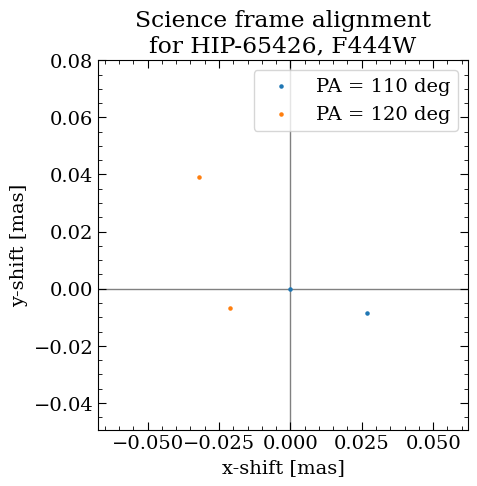

[spaceKLIP.imagetools:INFO]  Plot saved in data_nircam_hd65426/alignment_shifts/JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R_align_ref.pdf


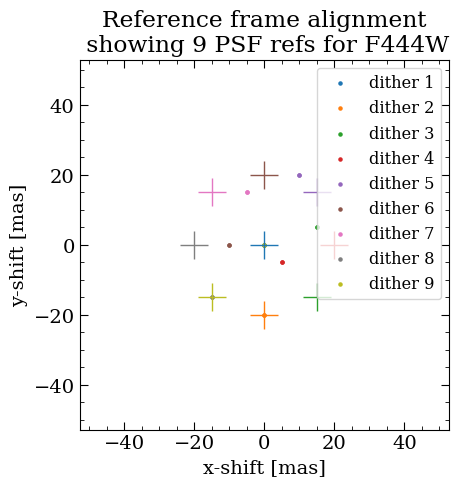

In [33]:
# Align Frames Use image registration to align all frames in a concatenation to the
# first science frame in that concatenation.
if first_sci_only == True:
    imageTools.calculate_alignment(method='fourier',
                                   kwargs={},
                                   subdir='alignment_shifts')

The plots output above illustrate the alignment corrections applied to each frame and also demonstrate the precision of the re-centering process. 

* **Science Frame Alignment Plot**: This plot shows the x and y shifts in milliarcseconds (mas) for all science frames, aligned relative to the first science frame, positioned at (0, 0).
* **Reference Frame Alignment Plot**: This plot displays the x and y shifts in milliarcseconds (mas) for all reference frames (PSF references) for the specified filter. The pre-aligned centers are indicated by markers in the legend, with the post-aligned positions marked by +. 

Files with multiple integrations are aligned separately, so there may be multiple pre-aligned centers plotted.



In [34]:
# This step also outputs plots that show the results of the alignment.
!ls data_nircam_hd65426/alignment_shifts/*pdf

data_nircam_hd65426/alignment_shifts/JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R_align_ref.pdf
data_nircam_hd65426/alignment_shifts/JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R_align_sci.pdf


In [35]:
# Open one to view the alignment of the reference images.
!open data_nircam_hd65426/alignment_shifts/*pdf

xdg-open: unexpected argument 'data_nircam_hd65426/alignment_shifts/JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R_align_sci.pdf'
Try 'xdg-open --help' for more information.


---

#### Shift Frames

Apply the shifts calculated in `calculate_centers` and `calculate_alignment` to the data.

In [36]:
imageTools.shift_frames(method='fourier', kwargs={}, subdir='shifted')

[spaceKLIP.imagetools:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.imagetools:INFO]   --> Estimated padding for shifting: 15 pixels
[spaceKLIP.imagetools:INFO]   --> Shift frames: jw01386002001_0310a_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Shift frames: jw01386003001_0310a_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Shift frames: jw01386001001_0310e_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Shift frames: jw01386001001_0310e_00002_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Shift frames: jw01386001001_0310e_00003_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Shift frames: jw01386001001_0310e_00004_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Shift frames: jw01386001001_0310e_00005_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Shift frames: jw01386001001_0310e_00006_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Shift frames: jw0138

Now, let’s compare before and after the shift.


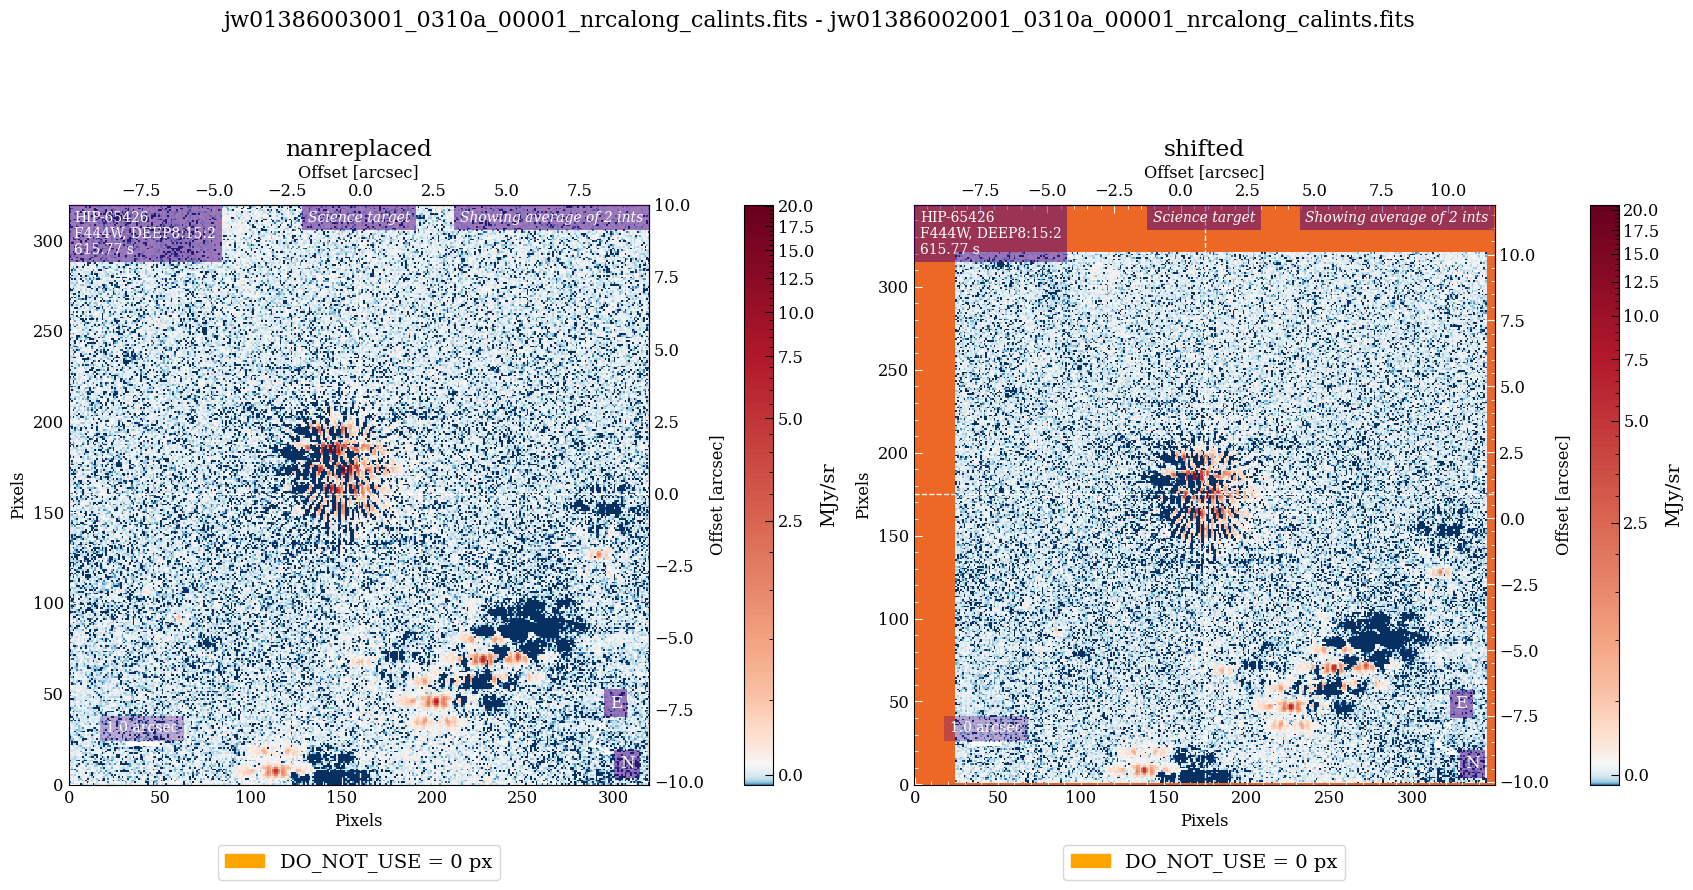

IntSlider(value=1, description='Image Index:', max=10, min=1)

Output()

In [37]:
# Compare how well recentering and alignment did.

spaceKLIP.plotting.display_image_comparisons(
    database,
    ['nanreplaced', 'shifted'],  # Subdirectories to look for files in.
    restrict_to={'FILTER': filt,  # Sort by filter.
                 'TYPE': ['SCI', 'REF']  # Sort by file type SCI/REF.
    },
    subtract_first=True,  # Subtract the first science frame to check alignment.
    interactive=True,  # Static or interactive plots?
    # Define the min/max/stretch values for consistent image scaling.
    # vmin=-0.5, vmax=0.5, stretch=0.05,
    save_filename=f'{data_root}/recenter_vs_align_{filt}_comparison.pdf'
    )

**Note**: After recentering and aligning, you may notice image wrapping effects, where parts of the image wrap around from one edge to the opposite edge. This can occur due to the way shifts and transformations are applied. This issue is currently under development to improve the handling of such effects.


---

### Pad Empty Space Around Frames

To give space to rotate and align during pyklip. This puts a region of NAN pixels around the outside. 

In [38]:
# Pad all frames.
imageTools.pad_frames(npix=80,
                      cval=np.nan,
                      types=['SCI', 'SCI_BG', 'REF', 'REF_BG'],
                      subdir='padded')

[spaceKLIP.imagetools:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.imagetools:INFO]   --> Frame padding: jw01386002001_0310a_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Frame padding: old shape = (350, 350), new shape = (510, 510), fill value = nan
[spaceKLIP.imagetools:INFO]   --> Frame padding: jw01386003001_0310a_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Frame padding: old shape = (350, 350), new shape = (510, 510), fill value = nan
[spaceKLIP.imagetools:INFO]   --> Frame padding: jw01386001001_0310e_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Frame padding: old shape = (350, 350), new shape = (510, 510), fill value = nan
[spaceKLIP.imagetools:INFO]   --> Frame padding: jw01386001001_0310e_00002_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Frame padding: old shape = (350, 350), new shape = (510, 510), fill value = nan
[spaceKLIP.imagetools:INFO]   --> Frame padding: jw013

---

### Display the Cleaned Datasets 

After applying all the previous steps, review the cleaned data. If you notice artifacts near bad pixels, it is likely that some were not identified and have persisted. To address this, you may need to revisit the bad pixel identification process, adjust the parameters, or add a custom bad pixel map.




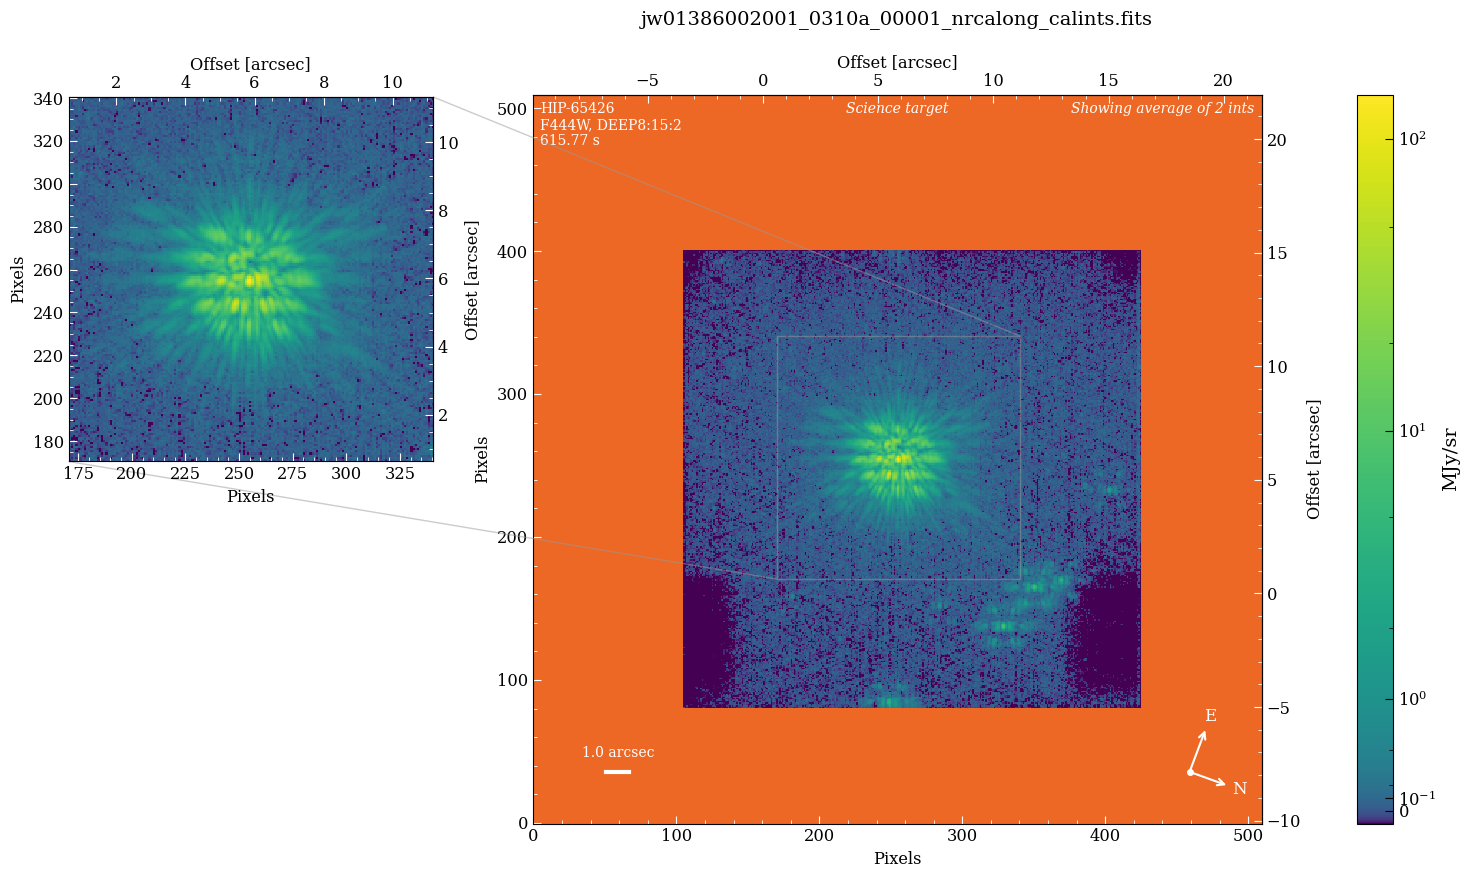

IntSlider(value=0, description='Image  Index:', max=1)

Output()

In [39]:
spaceKLIP.plotting.display_coron_dataset(
    database,
    restrict_to={'FILTER': filt,  # Sort by filter.
                 'TYPE': ['SCI']  # Sort by file type SCI/REF.
    },
    interactive=True,  # Set to False for static plots.
    zoom_center=3,  # Optional zoom factor; set to None to disable.
    bbox_color=None,  # Remove background text boxes.
    save_filename=f'{data_root}/plots_{filt}_stage2_cleaned.pdf'  # Save plots to PDF.
)

---

In [40]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.0f} seconds")

Runtime so far: 185 seconds


## Stage 3 Reductions: KLIP

### PSF Subtraction: Option Using pyKLIP

Now that we have cleaned up our data to account for alignment and bad pixels, we are ready to perform PSF subtraction. SpaceKLIP supports several algorithms for this step, including the recommended `pyKLIP`[↘️](https://pyklip.readthedocs.io/en/latest/index.html) and the JWST `Coron3Pipeline`[↘️](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.pipeline.Coron3Pipeline.html). In this case, we will use pyKLIP for subtraction.

You can customize the PSF subtraction process by adjusting the following settings:

> * `mode`: Choose from different image processing techniques, such as ADI, RDI, or a combination of both.
> * `annuli`: This parameter determines the number of concentric ring-shaped regions used for PSF subtraction. By specifying different numbers of annuli, you control the radial regions where the subtraction is applied, helping to remove the PSF at various distances from the center of the star. Default is [1].
> * `subsections`: This parameter defines the number of smaller regions or segments within each annulus where the PSF subtraction is applied. By breaking down the annuli into subsections, the algorithm can fine-tune the subtraction process. The default value is [1].
> * Number of KL Modes (`numbasis`): This parameter specifies how many Principal Component Analysis (PCA) modes are used to build the PSF model for subtraction. PCA modes capture different patterns and features in the data, allowing the model to represent and subtract the PSF more accurately. The default values are [1, 2, 5, 10, 20, 50, 100], which allows us to test different PSF models.
> * `algo`: Select the processing algorithm (here, klip).
> * `save_rolls`: A roll refers to a set of images taken during a specific pointing direction or orientation of the telescope. Enabling this parameter will save the PSF-subtracted versions of each individual science roll separately, in addition to the roll-combined final product.







These options help tailor the analysis to better suit your specific data and objectives.

In [41]:
# Run pyKLIP pipeline. Additional parameters for klip_dataset function can
# be passed using kwargs parameter.
spaceKLIP.pyklippipeline.run_obs(database=database,
                       kwargs={'mode': ['RDI', 'ADI+RDI'],
                               'annuli': [1],
                               'subsections': [1],
                               'numbasis': [1, 2, 5, 10, 20, 50],
                               'algo': 'klip',
                               'save_rolls': True},
                       subdir='klipsub')


[spaceKLIP.pyklippipeline:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.pyklippipeline:INFO]   --> pyKLIP: mode = RDI, annuli = 1, subsections = 1
Begin align and scale images for each wavelength
Wavelength 4.439e-06 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 1


  0%|          | 0/1 [00:00<?, ?it/s]

Closing threadpool
Derotating Images...
Writing Images to directory /home/cysil/JWST/projects/Coronography/NIRCam/data_nircam_hd65426/klipsub
wavelength collapsing reduced data of shape (b, N, wv, y, x):(6, 4, 1, 510, 510)
[spaceKLIP.pyklippipeline:INFO]   --> pyKLIP: mode = ADI+RDI, annuli = 1, subsections = 1
Begin align and scale images for each wavelength
Wavelength 4.439e-06 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 1


  0%|          | 0/1 [00:00<?, ?it/s]

Closing threadpool
Derotating Images...
Writing Images to directory /home/cysil/JWST/projects/Coronography/NIRCam/data_nircam_hd65426/klipsub
wavelength collapsing reduced data of shape (b, N, wv, y, x):(6, 4, 1, 510, 510)
[spaceKLIP.database:INFO] --> Identified 1 concatenation(s)
[spaceKLIP.database:INFO]   --> Concatenation 1: JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
 TYPE   EXP_TYPE DATAMODL TELESCOP ... SUBSECTS    KLMODES     BUNIT  BLURFWHM
------ --------- -------- -------- ... -------- -------------- ------ --------
PYKLIP NRC_CORON   STAGE3     JWST ...        1 1,2,5,10,20,50 MJy/sr      nan
PYKLIP NRC_CORON   STAGE3     JWST ...        1 1,2,5,10,20,50 MJy/sr      nan


The stage 3 information in the database is added to another table. The stage 2 information remains in the database, which is needed to maintain the information on rolls and references used in the reduction for forward modeling. 
In fact the stage 3 outputs include a JSON file that includes the table of the stage 2 data, so if you read in the stage 3 outputs it also learns about the stage 2 inputs.

In [42]:
database.summarize()

NIRCAM_F444W_MASK335R
	STAGE2: 11 files;	2 SCI, 9 REF
	STAGE3: 2 files;	2 PYKLIP


---

### Optional: Re-read Stage 3 Outputs into Database 
This shows how you can start re-analyses at this point, once you have run the previous steps.

Note, to read in stage 3 data you must set the `readlevel` parameter to 3. This invokes code for reading the stage-3 formatted data products, and also implicitly reads in the metadata about the stage 2 files used as input to stage 3. 

In [43]:
database = spaceKLIP.database.create_database(
                                    input_dir=os.path.join(data_root, 'klipsub'),
                                    file_type='*KLmodes-all.fits',
                                    output_dir=data_root,
                                    readlevel=3,
                                    pid=program)

[spaceKLIP.database:INFO] --> Identified 1 concatenation(s)
[spaceKLIP.database:INFO]   --> Concatenation 1: JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
 TYPE   EXP_TYPE DATAMODL TELESCOP ... SUBSECTS    KLMODES     BUNIT  BLURFWHM
------ --------- -------- -------- ... -------- -------------- ------ --------
PYKLIP NRC_CORON   STAGE3     JWST ...        1 1,2,5,10,20,50 MJy/sr      nan
PYKLIP NRC_CORON   STAGE3     JWST ...        1 1,2,5,10,20,50 MJy/sr      nan


In [44]:
database.summarize()

NIRCAM_F444W_MASK335R
	STAGE2: 11 files;	2 SCI, 9 REF
	STAGE3: 2 files;	2 PYKLIP


---

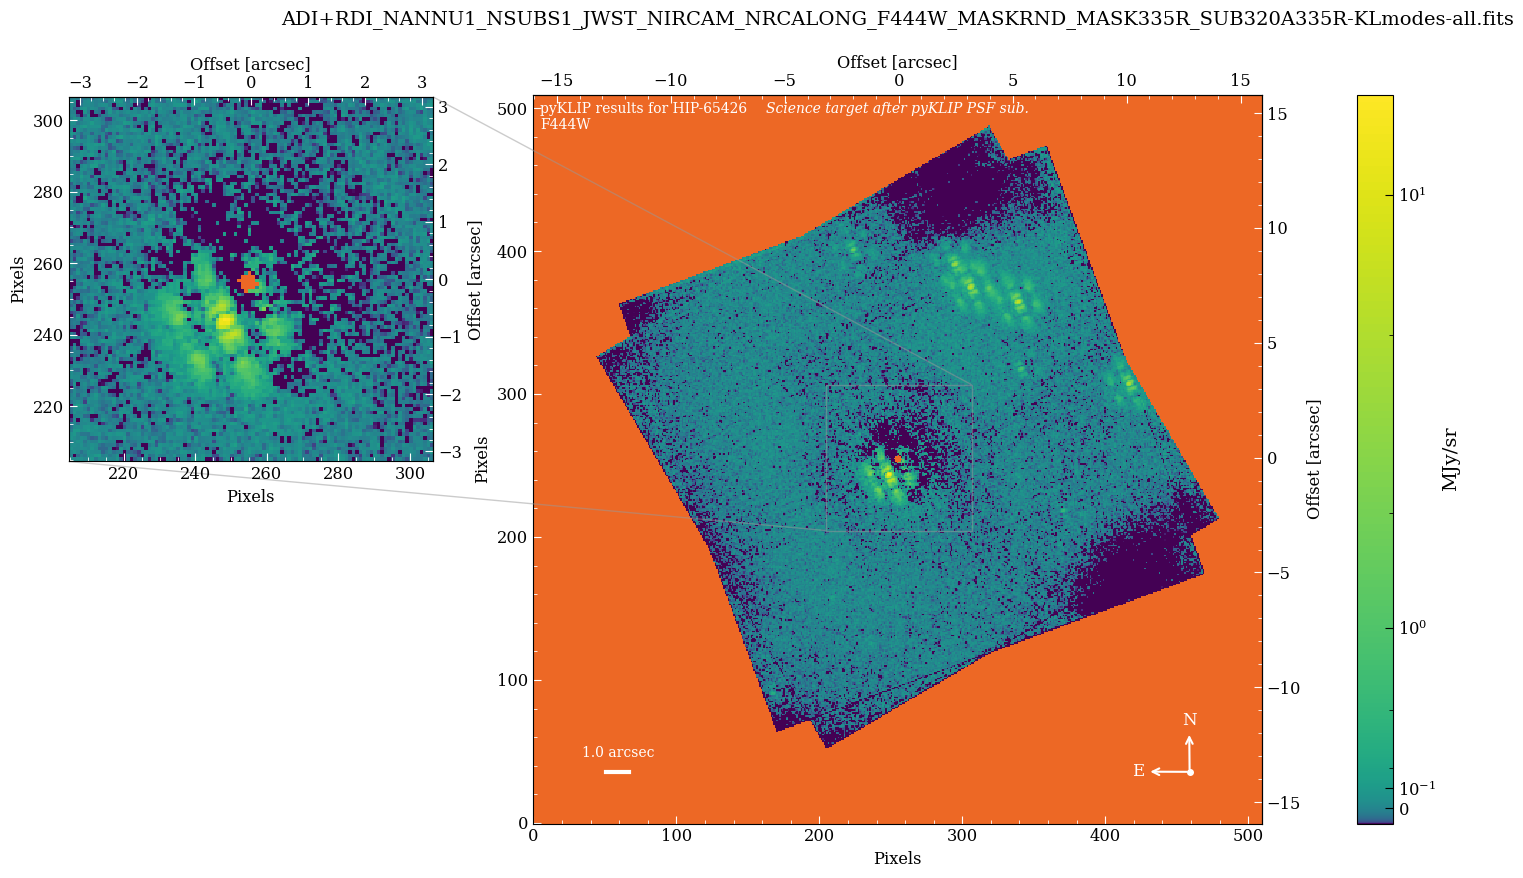

IntSlider(value=0, description='Image  Index:', max=1)

Output()

In [45]:
spaceKLIP.plotting.display_coron_dataset(
    database,
    stage3=True,
    restrict_to=filt,  # Sort by filter.
    interactive=True,  # Static or interactive plots?
    zoom_center=5,  # Optional zoom factor; set to None to disable.
    bbox_color=None,  # Remove background text boxes.
    save_filename=f'{data_root}/plots_{filt}_pyklip.pdf'  # Save plots to PDF.
)

Hurray! We’ve reached the end of the reduction process for NIRCam coronagraphic data. Now, we can move on to Part 2 of this tutorial to analyze the results. At this stage, the planet should appear to the lower left of the KLIP center (indicated by the orange point), along with other background sources. To get a closer look at the planet, consider increasing the `zoom_center` factor in the plot function above.

In [46]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.0f} seconds")

Runtime so far: 331 seconds
